In [1]:
!git clone http://github.com/Zapy67/ATML-PA-4 test

Cloning into 'test'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 408 (delta 267), reused 228 (delta 164), pack-reused 74 (from 1)
Receiving objects: 100% (408/408), 1.83 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [36]:
!git pull http://github.com/Zapy67/ATML-PA-4 test

remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 28 (delta 21), reused 26 (delta 19), pack-reused 0 (from 0)
Unpacking objects: 100% (28/28), 13.21 KiB | 250.00 KiB/s, done.
From http://github.com/Zapy67/ATML-PA-4
 * branch            test       -> FETCH_HEAD
Updating a14f059..d31a301
Fast-forward
 fed_lib/fed_methods.py |    4 +-
 fed_lib/utils.py       |    4 +-
 fedprox.ipynb          | 1272 +++++++++++++++++++--
 fedsam.ipynb           |  164 +--
 task2.ipynb            | 2931 +++++++++---------------------------------------
 5 files changed, 1742 insertions(+), 2633 deletions(-)


In [25]:
%cd test

[Errno 2] No such file or directory: 'test'
/kaggle/working/test


In [26]:
!ls

'ATML - PA 4.pdf'   fedprox.ipynb       README.md     task4.ipynb
 data		    fedsam.ipynb        task1.ipynb
 fedgh.ipynb	    fedscaffold.ipynb   task2.ipynb
 fed_lib	    LICENSE	        task3.ipynb


#  FedAvg & Local Optimization

In [37]:
import torch
import torch.nn as nn

In [ ]:
!pip install fedlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.0 MB/s eta 0:0

In [38]:
import fed_lib
import importlib
importlib.reload(fed_lib)

<module 'fed_lib' from '/kaggle/working/test/fed_lib/__init__.py'>

In [39]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(fed_methods)
importlib.reload(fed_model)
importlib.reload(utils)

<module 'fed_lib.utils' from '/kaggle/working/test/fed_lib/utils.py'>

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
trainset, testset = utils.get_cifar10()

In [32]:
import matplotlib.pyplot as plt
def plot_fed_vs_central_acc(metrics, title="FedAvg vs Central Test Accuracy"):
    """
    Args:
        metrics (dict): self.round_metrics dictionary from FedSGD.
    """
    fed_acc = metrics.get('fed_test_acc', [])
    central_acc = metrics.get('central_test_acc', [])

    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='FedAvg (Server) Accuracy')
    plt.plot(rounds, central_acc, marker='s', label='Central Model Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_fed_test_acc(metrics, title="Federated Test Accuracy"):
    fed_acc = metrics.get('fed_test_acc', [])
    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='Fed Test Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_client_drift(metrics, title="Client Drift Over Rounds"):
    drift = metrics.get('client_drift', [])
    rounds = list(range(1, len(drift) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, drift, marker='s', label='Client Drift')

    plt.xlabel("Round")
    plt.ylabel("Drift")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def fed_avg_exp(lr=1e-3, num_steps=5, num_clients=5, partition="dirichlet", alpha=10000,device=device, global_runs=20, verbose=False, sampling_frac=1.0):
        fed = fed_model.Federation(num_clients=num_clients, federate_method=None, partition=partition, domains=None, alpha=alpha, device=device, batch_size=64, pin_memory=True, num_workers=2)
        client_loaders = fed.client_dataloaders
        client_weights = [len(client.dataset.indices)/len(fed.centralized_train_loader) for client in client_loaders]
        
        fed_meth = fed_methods.FedAvg(local_epochs=1, aggregation_steps=num_steps, client_weights=client_weights, sample_fraction=sampling_frac)
        fed.set_method(fed_meth)
        fed.train(global_runs, lr=lr, verbose=verbose, train_central=False)

        return fed

In [43]:
import matplotlib.pyplot as plt

def plot_metrics(metrics:dict, title:str, label: str, label_desc:str):
    metric_map = {
        'fed_test_acc': 'Test Accuracy',
        'fed_test_loss': 'Test Loss',
        'client_drift': 'Client Drift (Norm)'
    }
    metric_order = ['fed_test_acc', 'fed_test_loss', 'client_drift']
    k_values = sorted(metrics.keys())

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    fig.suptitle(title, fontsize=14)


    for i, metric_key in enumerate(metric_order):
        ax = axes[i]
        for k in k_values:
            values = metrics[k][metric_key]
            rounds = list(range(1, len(values) + 1))
            ax.plot(rounds, values, label=f'{label}={k}')
            
        ax.set_ylabel(metric_map[metric_key])
        ax.grid(axis='y', linestyle='--', alpha=0.6)    
        ax.legend(title=f'{label_desc} ({label})', loc='upper left')
            
    axes[-1].set_xlabel('Global Round')
    plt.show()

In [33]:
#experimental setup 1.
from IPython.display import clear_output

metrics_exp_1 = {}
total_samples = len(trainset.dataset)
for k in [1, 5, 10, 20]: 
    f = fed_avg_exp(lr=1.5e-2, num_clients=5,num_steps=k, global_runs=50, sampling_frac=1.0)
    metrics_exp_1[k] = f.federated_method.round_metrics
    clear_output(wait=True)


--- Round 1/50 ---
Training Clients
Training Client 4/5 for 1 steps
Training Client 5/5 for 1 steps


KeyboardInterrupt: 

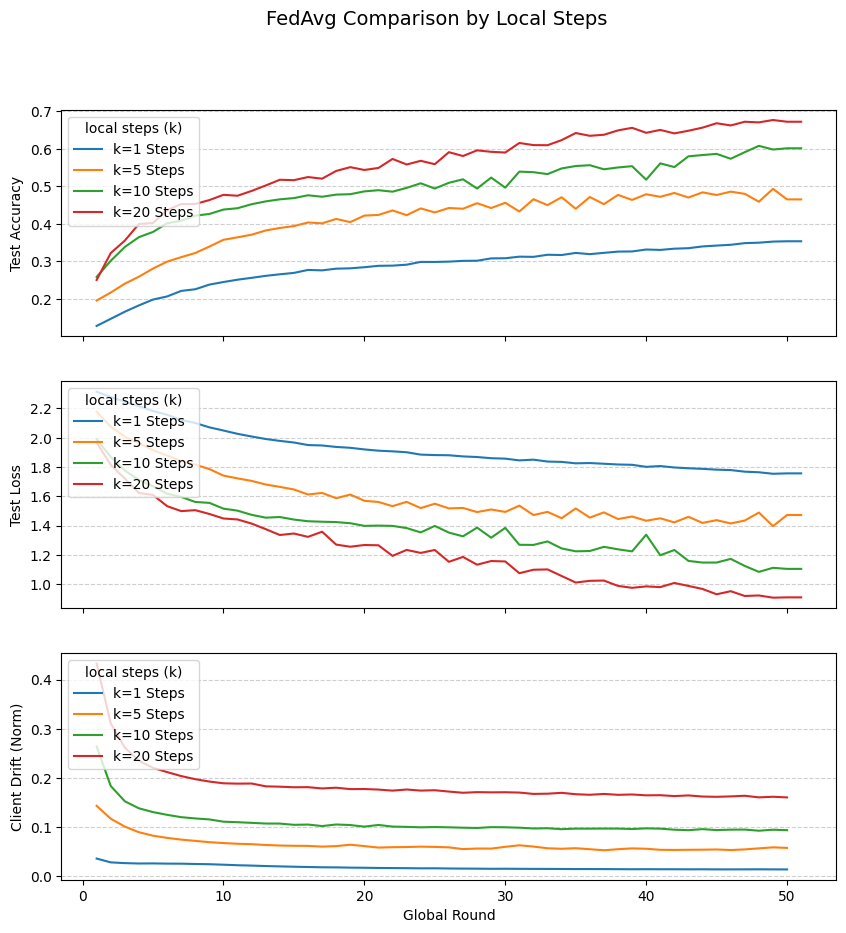

In [ ]:
plot_metrics(metrics_exp_1, title="FedAvg Comparison by Local Steps", label="k", label_desc="local steps")
print(metrics_exp_1)

In [40]:
#experimental setup 2.
from IPython.display import clear_output
metrics_exp_2 = {}
total_samples = len(trainset.dataset)

for frac in [0.2, 0.5, 1.0]: 
    f = fed_avg_exp(lr=1.5e-2, num_clients=5, num_steps=5, global_runs=50, sampling_frac=frac)
    metrics_exp_2[frac] = f.federated_method.round_metrics
    clear_output(wait=True)


--- Round 1/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.391480e-01
Client Drift Std: 1.412925e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.368204e-01
Client Number: 1 Drift :1.385660e-01
Client Number: 3 Drift :1.392368e-01
Client Number: 4 Drift :1.402122e-01
Client Number: 0 Drift :1.409044e-01

Evaluate on round 1:


FedAvg  | Test Loss: 2.1634, Test Acc: 23.62%

--- Round 2/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.219334e-01
Client Drift Std: 1.311230e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.198841e-01
Client Number: 1 Drift :1.214341e-01
Client Number: 3 Drift :1.221833e-01
Client Number: 0 Drift :1.222334e-01
Client Number: 4 Drift :1.239322e-01

Evaluate on round 2:


FedAvg  | Test Loss: 2.0246, Test Acc: 27.93%

--- Round 3/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 1.084745e-01
Client Drift Std: 7.088163e-04
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.073597e-01
Client Number: 4 Drift :1.083526e-01
Client Number: 2 Drift :1.084193e-01
Client Number: 1 Drift :1.086637e-01
Client Number: 0 Drift :1.095770e-01

Evaluate on round 3:


FedAvg  | Test Loss: 1.9164, Test Acc: 30.66%

--- Round 4/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 9.529486e-02
Client Drift Std: 5.197112e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :9.440162e-02
Client Number: 1 Drift :9.512722e-02
Client Number: 3 Drift :9.536579e-02
Client Number: 4 Drift :9.566843e-02
Client Number: 0 Drift :9.591125e-02

Evaluate on round 4:


FedAvg  | Test Loss: 1.8404, Test Acc: 33.20%

--- Round 5/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 8.450128e-02
Client Drift Std: 3.530880e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :8.398017e-02
Client Number: 1 Drift :8.419882e-02
Client Number: 0 Drift :8.462584e-02
Client Number: 3 Drift :8.483484e-02
Client Number: 4 Drift :8.486672e-02

Evaluate on round 5:


FedAvg  | Test Loss: 1.7837, Test Acc: 35.44%

--- Round 6/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 7.893868e-02
Client Drift Std: 4.290169e-04
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :7.828621e-02
Client Number: 2 Drift :7.856896e-02
Client Number: 3 Drift :7.922434e-02
Client Number: 0 Drift :7.925686e-02
Client Number: 4 Drift :7.935704e-02

Evaluate on round 6:


FedAvg  | Test Loss: 1.7442, Test Acc: 36.51%

--- Round 7/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 7.461665e-02
Client Drift Std: 7.059750e-04
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :7.355508e-02
Client Number: 2 Drift :7.423461e-02
Client Number: 3 Drift :7.466459e-02
Client Number: 0 Drift :7.496601e-02
Client Number: 4 Drift :7.566296e-02

Evaluate on round 7:


FedAvg  | Test Loss: 1.7003, Test Acc: 37.82%

--- Round 8/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 7.177521e-02
Client Drift Std: 3.157446e-04
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :7.139323e-02
Client Number: 2 Drift :7.160812e-02
Client Number: 1 Drift :7.162981e-02
Client Number: 4 Drift :7.194585e-02
Client Number: 0 Drift :7.229903e-02

Evaluate on round 8:


FedAvg  | Test Loss: 1.6708, Test Acc: 39.02%

--- Round 9/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.956071e-02
Client Drift Std: 1.332712e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :6.933419e-02
Client Number: 3 Drift :6.953532e-02
Client Number: 1 Drift :6.955802e-02
Client Number: 4 Drift :6.964092e-02
Client Number: 0 Drift :6.973509e-02

Evaluate on round 9:


FedAvg  | Test Loss: 1.6400, Test Acc: 40.09%

--- Round 10/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.811282e-02
Client Drift Std: 5.588104e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.716889e-02
Client Number: 1 Drift :6.794821e-02
Client Number: 3 Drift :6.826387e-02
Client Number: 2 Drift :6.830689e-02
Client Number: 0 Drift :6.887621e-02

Evaluate on round 10:


FedAvg  | Test Loss: 1.6161, Test Acc: 41.07%

--- Round 11/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.647313e-02
Client Drift Std: 6.367431e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.551810e-02
Client Number: 2 Drift :6.608004e-02
Client Number: 3 Drift :6.644536e-02
Client Number: 0 Drift :6.707966e-02
Client Number: 1 Drift :6.724251e-02

Evaluate on round 11:


FedAvg  | Test Loss: 1.5927, Test Acc: 41.54%

--- Round 12/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.500643e-02
Client Drift Std: 1.480746e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.487061e-02
Client Number: 2 Drift :6.488419e-02
Client Number: 4 Drift :6.495214e-02
Client Number: 3 Drift :6.505188e-02
Client Number: 1 Drift :6.527331e-02

Evaluate on round 12:


FedAvg  | Test Loss: 1.5695, Test Acc: 42.32%

--- Round 13/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.420386e-02
Client Drift Std: 8.299011e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.294734e-02
Client Number: 4 Drift :6.401166e-02
Client Number: 1 Drift :6.415736e-02
Client Number: 2 Drift :6.435656e-02
Client Number: 3 Drift :6.554640e-02

Evaluate on round 13:


FedAvg  | Test Loss: 1.5513, Test Acc: 42.93%

--- Round 14/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.291124e-02
Client Drift Std: 5.496042e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.191612e-02
Client Number: 0 Drift :6.277510e-02
Client Number: 3 Drift :6.315526e-02
Client Number: 2 Drift :6.319932e-02
Client Number: 1 Drift :6.351040e-02

Evaluate on round 14:


FedAvg  | Test Loss: 1.5298, Test Acc: 43.41%

--- Round 15/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.163698e-02
Client Drift Std: 1.135971e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.032614e-02
Client Number: 3 Drift :6.115248e-02
Client Number: 2 Drift :6.129846e-02
Client Number: 4 Drift :6.167731e-02
Client Number: 1 Drift :6.373052e-02

Evaluate on round 15:


FedAvg  | Test Loss: 1.5197, Test Acc: 43.57%

--- Round 16/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.096308e-02
Client Drift Std: 1.096999e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.977872e-02
Client Number: 2 Drift :6.037470e-02
Client Number: 3 Drift :6.072446e-02
Client Number: 1 Drift :6.092271e-02
Client Number: 4 Drift :6.301481e-02

Evaluate on round 16:


FedAvg  | Test Loss: 1.4975, Test Acc: 44.50%

--- Round 17/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.330915e-02
Client Drift Std: 2.033592e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.022848e-02
Client Number: 1 Drift :6.156396e-02
Client Number: 4 Drift :6.449065e-02
Client Number: 2 Drift :6.490272e-02
Client Number: 3 Drift :6.535997e-02

Evaluate on round 17:


FedAvg  | Test Loss: 1.5179, Test Acc: 43.86%

--- Round 18/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.466978e-02
Client Drift Std: 1.635782e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.258461e-02
Client Number: 3 Drift :6.377444e-02
Client Number: 0 Drift :6.399797e-02
Client Number: 2 Drift :6.575151e-02
Client Number: 1 Drift :6.724036e-02

Evaluate on round 18:


FedAvg  | Test Loss: 1.4957, Test Acc: 44.47%

--- Round 19/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.110571e-02
Client Drift Std: 1.682206e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.903392e-02
Client Number: 2 Drift :5.926936e-02
Client Number: 3 Drift :6.166901e-02
Client Number: 4 Drift :6.224272e-02
Client Number: 1 Drift :6.331353e-02

Evaluate on round 19:


FedAvg  | Test Loss: 1.4689, Test Acc: 45.51%

--- Round 20/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.991966e-02
Client Drift Std: 1.470869e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.723131e-02
Client Number: 4 Drift :5.976326e-02
Client Number: 3 Drift :6.030497e-02
Client Number: 1 Drift :6.070627e-02
Client Number: 0 Drift :6.159249e-02

Evaluate on round 20:


FedAvg  | Test Loss: 1.4539, Test Acc: 45.75%

--- Round 21/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.981489e-02
Client Drift Std: 3.051730e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.739082e-02
Client Number: 0 Drift :5.757032e-02
Client Number: 2 Drift :5.771002e-02
Client Number: 1 Drift :6.116693e-02
Client Number: 4 Drift :6.523638e-02

Evaluate on round 21:


FedAvg  | Test Loss: 1.4482, Test Acc: 46.07%

--- Round 22/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.920060e-02
Client Drift Std: 2.061932e-03
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :5.602450e-02
Client Number: 2 Drift :5.842552e-02
Client Number: 0 Drift :5.874718e-02
Client Number: 3 Drift :6.082686e-02
Client Number: 4 Drift :6.197894e-02

Evaluate on round 22:


FedAvg  | Test Loss: 1.4328, Test Acc: 47.17%

--- Round 23/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.299409e-02
Client Drift Std: 1.977069e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.057646e-02
Client Number: 2 Drift :6.061980e-02
Client Number: 0 Drift :6.413349e-02
Client Number: 3 Drift :6.460455e-02
Client Number: 1 Drift :6.503615e-02

Evaluate on round 23:


FedAvg  | Test Loss: 1.4435, Test Acc: 46.78%

--- Round 24/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.380291e-02
Client Drift Std: 2.989422e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.928765e-02
Client Number: 4 Drift :6.175089e-02
Client Number: 1 Drift :6.420977e-02
Client Number: 3 Drift :6.619610e-02
Client Number: 2 Drift :6.757013e-02

Evaluate on round 24:


FedAvg  | Test Loss: 1.4259, Test Acc: 47.57%

--- Round 25/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.891255e-02
Client Drift Std: 1.147259e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.677436e-02
Client Number: 1 Drift :5.880557e-02
Client Number: 4 Drift :5.933084e-02
Client Number: 0 Drift :5.954855e-02
Client Number: 3 Drift :6.010345e-02

Evaluate on round 25:


FedAvg  | Test Loss: 1.4017, Test Acc: 48.12%

--- Round 26/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.631994e-02
Client Drift Std: 8.561901e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.482707e-02
Client Number: 4 Drift :5.621567e-02
Client Number: 1 Drift :5.623882e-02
Client Number: 0 Drift :5.708508e-02
Client Number: 3 Drift :5.723304e-02

Evaluate on round 26:


FedAvg  | Test Loss: 1.3867, Test Acc: 48.70%

--- Round 27/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.958920e-02
Client Drift Std: 3.746086e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.506035e-02
Client Number: 2 Drift :5.603549e-02
Client Number: 1 Drift :5.928771e-02
Client Number: 3 Drift :6.283543e-02
Client Number: 4 Drift :6.472705e-02

Evaluate on round 27:


FedAvg  | Test Loss: 1.3819, Test Acc: 48.99%

--- Round 28/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.846348e-02
Client Drift Std: 3.882270e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.523562e-02
Client Number: 0 Drift :5.583741e-02
Client Number: 2 Drift :5.637459e-02
Client Number: 1 Drift :5.910794e-02
Client Number: 4 Drift :6.576183e-02

Evaluate on round 28:


FedAvg  | Test Loss: 1.3822, Test Acc: 49.24%

--- Round 29/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.852358e-02
Client Drift Std: 1.809857e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.653787e-02
Client Number: 0 Drift :5.722770e-02
Client Number: 1 Drift :5.770832e-02
Client Number: 2 Drift :5.965034e-02
Client Number: 4 Drift :6.149365e-02

Evaluate on round 29:


FedAvg  | Test Loss: 1.3696, Test Acc: 49.29%

--- Round 30/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.386171e-02
Client Drift Std: 1.891715e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :6.056656e-02
Client Number: 4 Drift :6.288549e-02
Client Number: 2 Drift :6.527355e-02
Client Number: 0 Drift :6.528416e-02
Client Number: 1 Drift :6.529881e-02

Evaluate on round 30:


FedAvg  | Test Loss: 1.3951, Test Acc: 49.33%

--- Round 31/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.085541e-02
Client Drift Std: 2.714043e-03
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :5.695486e-02
Client Number: 3 Drift :5.939254e-02
Client Number: 2 Drift :6.134713e-02
Client Number: 4 Drift :6.137194e-02
Client Number: 0 Drift :6.521056e-02

Evaluate on round 31:


FedAvg  | Test Loss: 1.3536, Test Acc: 49.71%

--- Round 32/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.614274e-02
Client Drift Std: 1.835965e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.387446e-02
Client Number: 4 Drift :5.392188e-02
Client Number: 1 Drift :5.747976e-02
Client Number: 2 Drift :5.761635e-02
Client Number: 3 Drift :5.782124e-02

Evaluate on round 32:


FedAvg  | Test Loss: 1.3385, Test Acc: 51.26%

--- Round 33/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.746071e-02
Client Drift Std: 3.018891e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.348351e-02
Client Number: 2 Drift :5.521057e-02
Client Number: 3 Drift :5.738256e-02
Client Number: 0 Drift :5.906402e-02
Client Number: 1 Drift :6.216290e-02

Evaluate on round 33:


FedAvg  | Test Loss: 1.3450, Test Acc: 50.84%

--- Round 34/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.957249e-02
Client Drift Std: 3.213540e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.425845e-02
Client Number: 4 Drift :5.744429e-02
Client Number: 1 Drift :6.171039e-02
Client Number: 3 Drift :6.188745e-02
Client Number: 2 Drift :6.256185e-02

Evaluate on round 34:


FedAvg  | Test Loss: 1.3323, Test Acc: 51.21%

--- Round 35/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.856692e-02
Client Drift Std: 1.868816e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.489291e-02
Client Number: 3 Drift :5.896553e-02
Client Number: 1 Drift :5.942397e-02
Client Number: 0 Drift :5.950559e-02
Client Number: 2 Drift :6.004662e-02

Evaluate on round 35:


FedAvg  | Test Loss: 1.3175, Test Acc: 51.97%

--- Round 36/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.717701e-02
Client Drift Std: 3.137716e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.413971e-02
Client Number: 0 Drift :5.500393e-02
Client Number: 1 Drift :5.617890e-02
Client Number: 2 Drift :5.754173e-02
Client Number: 4 Drift :6.302077e-02

Evaluate on round 36:


FedAvg  | Test Loss: 1.3158, Test Acc: 52.24%

--- Round 37/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.071281e-02
Client Drift Std: 4.370182e-03
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :5.547874e-02
Client Number: 2 Drift :5.654446e-02
Client Number: 3 Drift :6.194364e-02
Client Number: 4 Drift :6.198620e-02
Client Number: 0 Drift :6.761102e-02

Evaluate on round 37:


FedAvg  | Test Loss: 1.3444, Test Acc: 50.29%

--- Round 38/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.258844e-02
Client Drift Std: 2.872345e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.855347e-02
Client Number: 1 Drift :6.015590e-02
Client Number: 4 Drift :6.296846e-02
Client Number: 2 Drift :6.519603e-02
Client Number: 3 Drift :6.606833e-02

Evaluate on round 38:


FedAvg  | Test Loss: 1.3123, Test Acc: 52.52%

--- Round 39/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.120291e-02
Client Drift Std: 2.066244e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.942384e-02
Client Number: 4 Drift :5.983978e-02
Client Number: 2 Drift :6.052363e-02
Client Number: 1 Drift :6.104481e-02
Client Number: 3 Drift :6.518251e-02

Evaluate on round 39:


FedAvg  | Test Loss: 1.3253, Test Acc: 51.26%

--- Round 40/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.957096e-02
Client Drift Std: 8.652211e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.851816e-02
Client Number: 3 Drift :5.890379e-02
Client Number: 2 Drift :5.926846e-02
Client Number: 4 Drift :6.041959e-02
Client Number: 1 Drift :6.074478e-02

Evaluate on round 40:


FedAvg  | Test Loss: 1.3006, Test Acc: 53.27%

--- Round 41/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.622264e-02
Client Drift Std: 1.364502e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.427912e-02
Client Number: 4 Drift :5.505712e-02
Client Number: 2 Drift :5.655130e-02
Client Number: 3 Drift :5.729630e-02
Client Number: 1 Drift :5.792935e-02

Evaluate on round 41:


FedAvg  | Test Loss: 1.2850, Test Acc: 53.04%

--- Round 42/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.492564e-02
Client Drift Std: 1.377237e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.243755e-02
Client Number: 1 Drift :5.446720e-02
Client Number: 2 Drift :5.556397e-02
Client Number: 3 Drift :5.600312e-02
Client Number: 4 Drift :5.615638e-02

Evaluate on round 42:


FedAvg  | Test Loss: 1.2670, Test Acc: 53.88%

--- Round 43/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.712135e-02
Client Drift Std: 2.305922e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.297489e-02
Client Number: 4 Drift :5.638215e-02
Client Number: 0 Drift :5.825615e-02
Client Number: 3 Drift :5.848460e-02
Client Number: 1 Drift :5.950895e-02

Evaluate on round 43:


FedAvg  | Test Loss: 1.2599, Test Acc: 54.39%

--- Round 44/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.727487e-02
Client Drift Std: 3.964700e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.295202e-02
Client Number: 0 Drift :5.529665e-02
Client Number: 2 Drift :5.614694e-02
Client Number: 3 Drift :5.730653e-02
Client Number: 1 Drift :6.467221e-02

Evaluate on round 44:


FedAvg  | Test Loss: 1.2795, Test Acc: 53.09%

--- Round 45/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.755577e-02
Client Drift Std: 1.336805e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.587053e-02
Client Number: 1 Drift :5.661767e-02
Client Number: 0 Drift :5.754063e-02
Client Number: 3 Drift :5.794385e-02
Client Number: 2 Drift :5.980618e-02

Evaluate on round 45:


FedAvg  | Test Loss: 1.2584, Test Acc: 54.65%

--- Round 46/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.943044e-02
Client Drift Std: 1.083191e-03
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :5.786277e-02
Client Number: 3 Drift :5.908799e-02
Client Number: 2 Drift :5.910084e-02
Client Number: 0 Drift :5.996944e-02
Client Number: 4 Drift :6.113117e-02

Evaluate on round 46:


FedAvg  | Test Loss: 1.2904, Test Acc: 52.45%

--- Round 47/50 ---
Training Clients
Training Client 4/5 for 5 steps


Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.996197e-02
Client Drift Std: 2.444640e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.594536e-02
Client Number: 1 Drift :5.914351e-02
Client Number: 3 Drift :5.974098e-02
Client Number: 4 Drift :6.213817e-02
Client Number: 0 Drift :6.284183e-02

Evaluate on round 47:


FedAvg  | Test Loss: 1.2426, Test Acc: 55.18%

--- Round 48/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.803293e-02
Client Drift Std: 3.563499e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.488299e-02
Client Number: 1 Drift :5.588323e-02
Client Number: 0 Drift :5.599175e-02
Client Number: 3 Drift :5.871678e-02
Client Number: 2 Drift :6.468990e-02

Evaluate on round 48:


FedAvg  | Test Loss: 1.2624, Test Acc: 54.73%

--- Round 49/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.588145e-02
Client Drift Std: 8.532208e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.670656e-02
Client Number: 4 Drift :6.025627e-02
Client Number: 0 Drift :6.126071e-02
Client Number: 1 Drift :7.121945e-02
Client Number: 3 Drift :7.996428e-02

Evaluate on round 49:


FedAvg  | Test Loss: 1.2986, Test Acc: 53.36%

--- Round 50/50 ---
Training Clients
Training Client 4/5 for 5 steps
Training Client 5/5 for 5 steps
Training Client 1/5 for 5 steps
Training Client 2/5 for 5 steps
Training Client 3/5 for 5 steps
Training Server

Client Drift Stats:
Client Drift Mean: 6.299757e-02
Client Drift Std: 2.972395e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.841190e-02
Client Number: 2 Drift :6.133473e-02
Client Number: 3 Drift :6.288549e-02
Client Number: 1 Drift :6.591202e-02
Client Number: 4 Drift :6.644368e-02

Evaluate on round 50:


FedAvg  | Test Loss: 1.2400, Test Acc: 55.45%
Training Complete!


FedAvg  | Test Loss: 1.2400, Test Acc: 55.45%


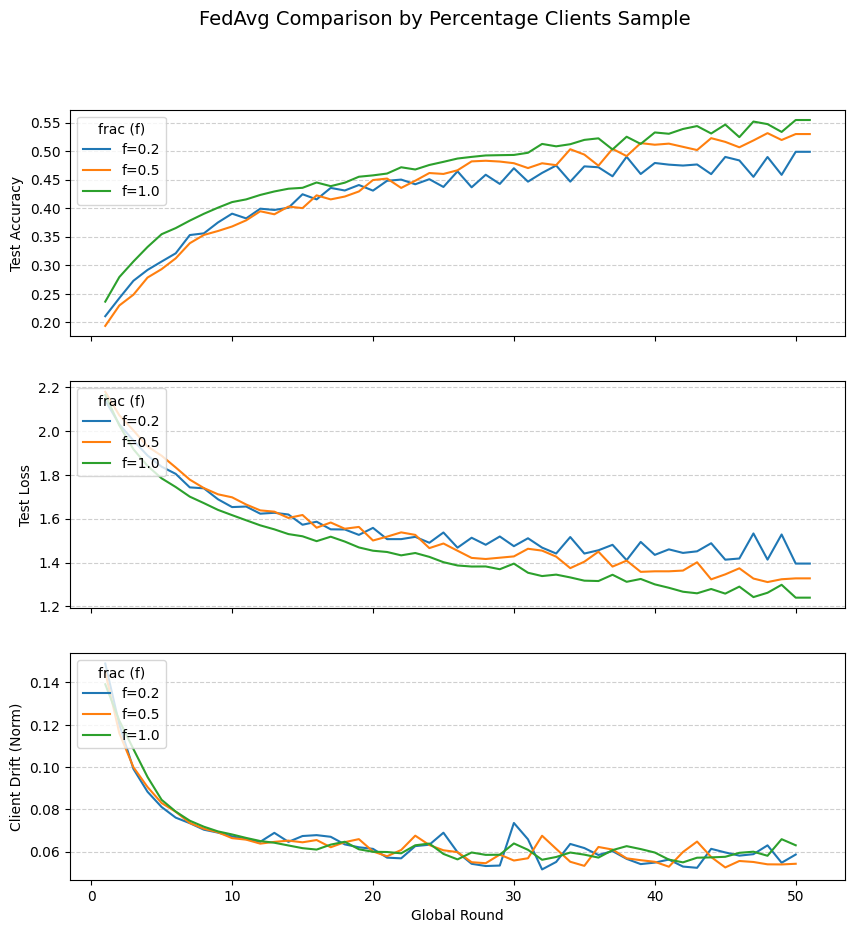

In [ ]:
plot_metrics(metrics_exp_2, title="FedAvg Comparison by Percentage Clients Sample", label="f", label_desc="frac")
print(metrics_exp_2)

In [50]:
#experimental setup 3.
metrics_exp_3 = {}
for alpha in [1e-4, 0.01, 0.1, 1,10]: 
    f = fed_avg_exp(lr=1e-2, num_clients=5,num_steps=75, global_runs=30, alpha=alpha, sampling_frac=1)
    metrics_exp_3[alpha] = f.federated_method.round_metrics
    clear_output(wait=True)


--- Round 1/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 7.509121e-01
Client Drift Std: 4.373969e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :7.037771e-01
Client Number: 1 Drift :7.108923e-01
Client Number: 4 Drift :7.363944e-01
Client Number: 2 Drift :7.882746e-01
Client Number: 0 Drift :8.152221e-01

Evaluate on round 1:


FedAvg  | Test Loss: 1.7542, Test Acc: 35.44%

--- Round 2/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 5.351433e-01
Client Drift Std: 4.148199e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :4.929932e-01
Client Number: 1 Drift :4.996390e-01
Client Number: 4 Drift :5.125067e-01
Client Number: 2 Drift :5.817488e-01
Client Number: 0 Drift :5.888286e-01

Evaluate on round 2:


FedAvg  | Test Loss: 1.5895, Test Acc: 41.67%

--- Round 3/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.631510e-01
Client Drift Std: 3.981629e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :4.170647e-01
Client Number: 1 Drift :4.322346e-01
Client Number: 4 Drift :4.451758e-01
Client Number: 2 Drift :5.080510e-01
Client Number: 0 Drift :5.132289e-01

Evaluate on round 3:


FedAvg  | Test Loss: 1.5194, Test Acc: 44.35%

--- Round 4/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.319564e-01
Client Drift Std: 3.656051e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.955132e-01
Client Number: 3 Drift :4.000807e-01
Client Number: 4 Drift :4.117452e-01
Client Number: 2 Drift :4.737799e-01
Client Number: 0 Drift :4.786628e-01

Evaluate on round 4:


FedAvg  | Test Loss: 1.4593, Test Acc: 46.81%

--- Round 5/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 4.089806e-01
Client Drift Std: 3.454434e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.743631e-01
Client Number: 1 Drift :3.818679e-01
Client Number: 4 Drift :3.872087e-01
Client Number: 2 Drift :4.446990e-01
Client Number: 0 Drift :4.567641e-01

Evaluate on round 5:


FedAvg  | Test Loss: 1.4253, Test Acc: 48.17%

--- Round 6/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.975585e-01
Client Drift Std: 3.227375e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.620315e-01
Client Number: 1 Drift :3.720178e-01
Client Number: 4 Drift :3.811262e-01
Client Number: 2 Drift :4.331203e-01
Client Number: 0 Drift :4.394968e-01

Evaluate on round 6:


FedAvg  | Test Loss: 1.4366, Test Acc: 48.26%

--- Round 7/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.868300e-01
Client Drift Std: 2.852330e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.571457e-01
Client Number: 1 Drift :3.635281e-01
Client Number: 4 Drift :3.712441e-01
Client Number: 2 Drift :4.161272e-01
Client Number: 0 Drift :4.261049e-01

Evaluate on round 7:


FedAvg  | Test Loss: 1.3653, Test Acc: 51.01%

--- Round 8/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.826919e-01
Client Drift Std: 2.839344e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.527160e-01
Client Number: 1 Drift :3.611757e-01
Client Number: 4 Drift :3.654318e-01
Client Number: 2 Drift :4.150561e-01
Client Number: 0 Drift :4.190798e-01

Evaluate on round 8:


FedAvg  | Test Loss: 1.2951, Test Acc: 53.20%

--- Round 9/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.755384e-01
Client Drift Std: 3.091253e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.441956e-01
Client Number: 1 Drift :3.477452e-01
Client Number: 4 Drift :3.602726e-01
Client Number: 2 Drift :4.094031e-01
Client Number: 0 Drift :4.160752e-01

Evaluate on round 9:


FedAvg  | Test Loss: 1.2649, Test Acc: 54.33%

--- Round 10/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.693901e-01
Client Drift Std: 2.793130e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.406264e-01
Client Number: 1 Drift :3.451542e-01
Client Number: 4 Drift :3.558725e-01
Client Number: 2 Drift :3.959003e-01
Client Number: 0 Drift :4.093969e-01

Evaluate on round 10:


FedAvg  | Test Loss: 1.2248, Test Acc: 55.73%

--- Round 11/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.634903e-01
Client Drift Std: 2.955318e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.332720e-01
Client Number: 1 Drift :3.380708e-01
Client Number: 4 Drift :3.485892e-01
Client Number: 2 Drift :3.917687e-01
Client Number: 0 Drift :4.057508e-01

Evaluate on round 11:


FedAvg  | Test Loss: 1.1782, Test Acc: 57.76%

--- Round 12/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.573693e-01
Client Drift Std: 2.854531e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.283291e-01
Client Number: 1 Drift :3.351991e-01
Client Number: 4 Drift :3.397804e-01
Client Number: 2 Drift :3.861451e-01
Client Number: 0 Drift :3.973931e-01

Evaluate on round 12:


FedAvg  | Test Loss: 1.1525, Test Acc: 58.78%

--- Round 13/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.533735e-01
Client Drift Std: 3.024886e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.199412e-01
Client Number: 1 Drift :3.286405e-01
Client Number: 4 Drift :3.391752e-01
Client Number: 2 Drift :3.859707e-01
Client Number: 0 Drift :3.931398e-01

Evaluate on round 13:


FedAvg  | Test Loss: 1.1625, Test Acc: 58.66%

--- Round 14/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.478360e-01
Client Drift Std: 2.900082e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.213015e-01
Client Number: 1 Drift :3.238678e-01
Client Number: 4 Drift :3.275690e-01
Client Number: 2 Drift :3.807959e-01
Client Number: 0 Drift :3.856457e-01

Evaluate on round 14:


FedAvg  | Test Loss: 1.1228, Test Acc: 60.23%

--- Round 15/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.456607e-01
Client Drift Std: 2.979226e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.168553e-01
Client Number: 1 Drift :3.231961e-01
Client Number: 4 Drift :3.244437e-01
Client Number: 2 Drift :3.782894e-01
Client Number: 0 Drift :3.855191e-01

Evaluate on round 15:


FedAvg  | Test Loss: 1.1106, Test Acc: 60.73%

--- Round 16/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.422357e-01
Client Drift Std: 2.735002e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.167438e-01
Client Number: 1 Drift :3.192494e-01
Client Number: 4 Drift :3.240488e-01
Client Number: 0 Drift :3.734421e-01
Client Number: 2 Drift :3.776942e-01

Evaluate on round 16:


FedAvg  | Test Loss: 1.1066, Test Acc: 60.87%

--- Round 17/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.370273e-01
Client Drift Std: 2.729097e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.097182e-01
Client Number: 3 Drift :3.137127e-01
Client Number: 4 Drift :3.217672e-01
Client Number: 2 Drift :3.660049e-01
Client Number: 0 Drift :3.739333e-01

Evaluate on round 17:


FedAvg  | Test Loss: 1.0960, Test Acc: 61.27%

--- Round 18/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.356599e-01
Client Drift Std: 2.708186e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.081886e-01
Client Number: 1 Drift :3.127259e-01
Client Number: 4 Drift :3.205999e-01
Client Number: 2 Drift :3.654911e-01
Client Number: 0 Drift :3.712941e-01

Evaluate on round 18:


FedAvg  | Test Loss: 1.0521, Test Acc: 62.61%

--- Round 19/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.333315e-01
Client Drift Std: 2.638815e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.077134e-01
Client Number: 3 Drift :3.114001e-01
Client Number: 4 Drift :3.169123e-01
Client Number: 2 Drift :3.615199e-01
Client Number: 0 Drift :3.691117e-01

Evaluate on round 19:


FedAvg  | Test Loss: 1.0406, Test Acc: 63.08%

--- Round 20/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.343022e-01
Client Drift Std: 2.887096e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.065756e-01
Client Number: 1 Drift :3.126065e-01
Client Number: 4 Drift :3.135675e-01
Client Number: 2 Drift :3.650655e-01
Client Number: 0 Drift :3.736962e-01

Evaluate on round 20:


FedAvg  | Test Loss: 1.0701, Test Acc: 62.41%

--- Round 21/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.310209e-01
Client Drift Std: 2.908776e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.028837e-01
Client Number: 1 Drift :3.057409e-01
Client Number: 4 Drift :3.139066e-01
Client Number: 2 Drift :3.631670e-01
Client Number: 0 Drift :3.694062e-01

Evaluate on round 21:


FedAvg  | Test Loss: 1.0402, Test Acc: 63.14%

--- Round 22/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.297096e-01
Client Drift Std: 2.892631e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.040074e-01
Client Number: 3 Drift :3.043436e-01
Client Number: 4 Drift :3.104890e-01
Client Number: 2 Drift :3.603864e-01
Client Number: 0 Drift :3.693218e-01

Evaluate on round 22:


FedAvg  | Test Loss: 0.9980, Test Acc: 64.89%

--- Round 23/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.287613e-01
Client Drift Std: 2.923050e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :3.004953e-01
Client Number: 3 Drift :3.041085e-01
Client Number: 4 Drift :3.109819e-01
Client Number: 2 Drift :3.591021e-01
Client Number: 0 Drift :3.691187e-01

Evaluate on round 23:


FedAvg  | Test Loss: 0.9309, Test Acc: 67.01%

--- Round 24/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.267984e-01
Client Drift Std: 2.796799e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :2.971306e-01
Client Number: 1 Drift :3.048481e-01
Client Number: 4 Drift :3.107835e-01
Client Number: 2 Drift :3.589593e-01
Client Number: 0 Drift :3.622702e-01

Evaluate on round 24:


FedAvg  | Test Loss: 0.9692, Test Acc: 65.97%

--- Round 25/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.277931e-01
Client Drift Std: 2.820361e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.029010e-01
Client Number: 1 Drift :3.049350e-01
Client Number: 4 Drift :3.067195e-01
Client Number: 2 Drift :3.588380e-01
Client Number: 0 Drift :3.655718e-01

Evaluate on round 25:


FedAvg  | Test Loss: 0.9468, Test Acc: 66.56%

--- Round 26/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.258647e-01
Client Drift Std: 2.967236e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :2.994874e-01
Client Number: 1 Drift :2.995990e-01
Client Number: 4 Drift :3.060955e-01
Client Number: 2 Drift :3.606530e-01
Client Number: 0 Drift :3.634886e-01

Evaluate on round 26:


FedAvg  | Test Loss: 0.9476, Test Acc: 66.59%

--- Round 27/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.233622e-01
Client Drift Std: 2.718228e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.991429e-01
Client Number: 3 Drift :3.000849e-01
Client Number: 4 Drift :3.045339e-01
Client Number: 2 Drift :3.540778e-01
Client Number: 0 Drift :3.589715e-01

Evaluate on round 27:


FedAvg  | Test Loss: 0.9436, Test Acc: 66.73%

--- Round 28/30 ---
Training Clients
Training Client 4/5 for 75 steps


Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.256722e-01
Client Drift Std: 2.806247e-02
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :2.995121e-01
Client Number: 1 Drift :3.026404e-01
Client Number: 4 Drift :3.065125e-01
Client Number: 2 Drift :3.567153e-01
Client Number: 0 Drift :3.629808e-01

Evaluate on round 28:


FedAvg  | Test Loss: 0.9206, Test Acc: 67.51%

--- Round 29/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.244113e-01
Client Drift Std: 3.009354e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.949130e-01
Client Number: 3 Drift :2.972134e-01
Client Number: 4 Drift :3.082655e-01
Client Number: 2 Drift :3.593203e-01
Client Number: 0 Drift :3.623442e-01

Evaluate on round 29:


FedAvg  | Test Loss: 0.9425, Test Acc: 67.58%

--- Round 30/30 ---
Training Clients
Training Client 4/5 for 75 steps
Training Client 5/5 for 75 steps
Training Client 1/5 for 75 steps
Training Client 2/5 for 75 steps
Training Client 3/5 for 75 steps
Training Server

Client Drift Stats:
Client Drift Mean: 3.234537e-01
Client Drift Std: 2.657832e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :2.978198e-01
Client Number: 3 Drift :3.013510e-01
Client Number: 4 Drift :3.065156e-01
Client Number: 0 Drift :3.537791e-01
Client Number: 2 Drift :3.578031e-01

Evaluate on round 30:


FedAvg  | Test Loss: 0.8924, Test Acc: 68.51%
Training Complete!


FedAvg  | Test Loss: 0.8924, Test Acc: 68.51%


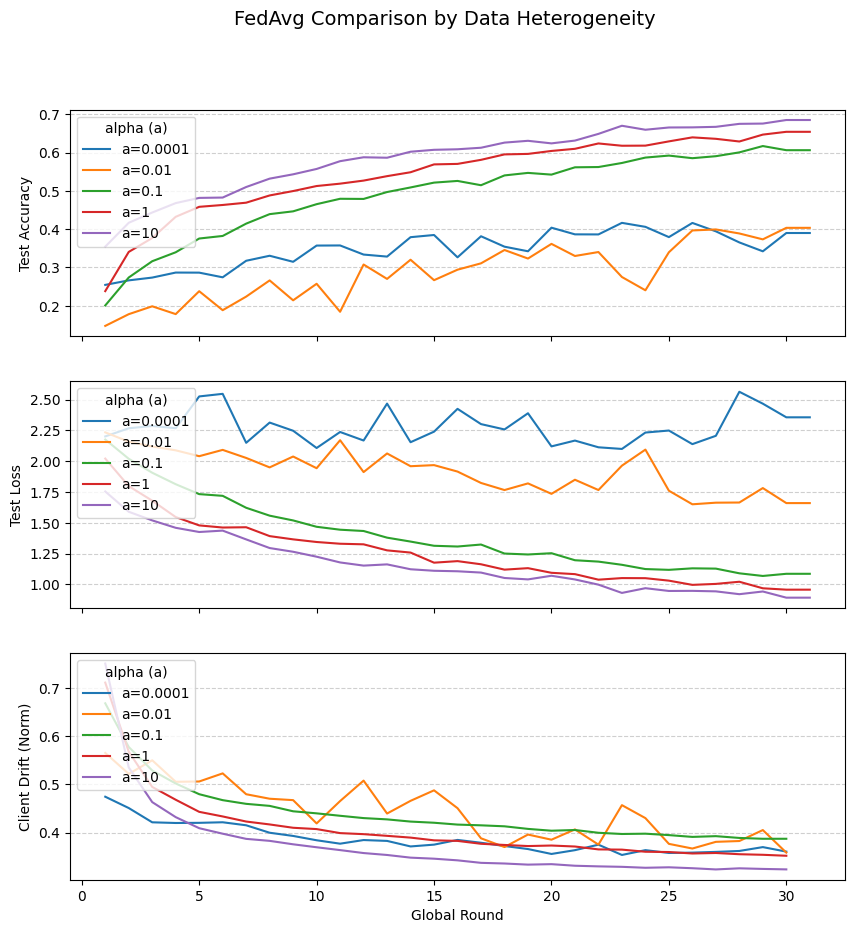

In [ ]:
plot_metrics(metrics_exp_3, title="FedAvg Comparison by Data Heterogeneity", label="a", label_desc="alpha")
print(metrics_exp_3)